In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Which marketing promotion is best?

Let's test it out using an alpha of 0.05.


In [2]:
df = pd.read_csv('WA_Marketing-Campaign.csv')
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [9]:
df.isnull().sum().sum()

0

In [5]:
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [10]:
# check how much data we have for each promotion and avg sales of each promotion
df.groupby('Promotion').agg({'SalesInThousands':['count','mean']})

SalesInThousands           
                     count       mean
Promotion                            
1                      172  58.099012
2                      188  47.329415
3                      188  55.364468

## Checking Normality

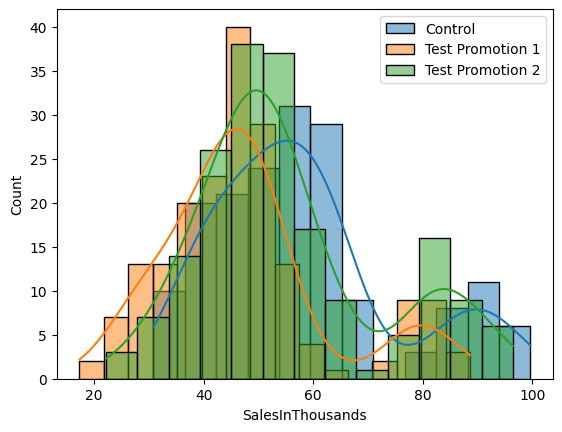

In [3]:
control = df[df.Promotion == 1]
test_1 = df[df.Promotion == 2]
test_2 = df[df.Promotion == 3]

# plot probability distributions

sns.histplot(control['SalesInThousands'], kde=True, label='Control')
sns.histplot(test_1['SalesInThousands'], kde=True, label='Test Promotion 1')
sns.histplot(test_2['SalesInThousands'], kde=True, label='Test Promotion 2')

plt.legend()
plt.show()

The distributions do not seem to be normal distributions

All 3 groups' pvalues are smaller than .05, meaning we reject the null hypothesis and they do not meet normality assumptions.

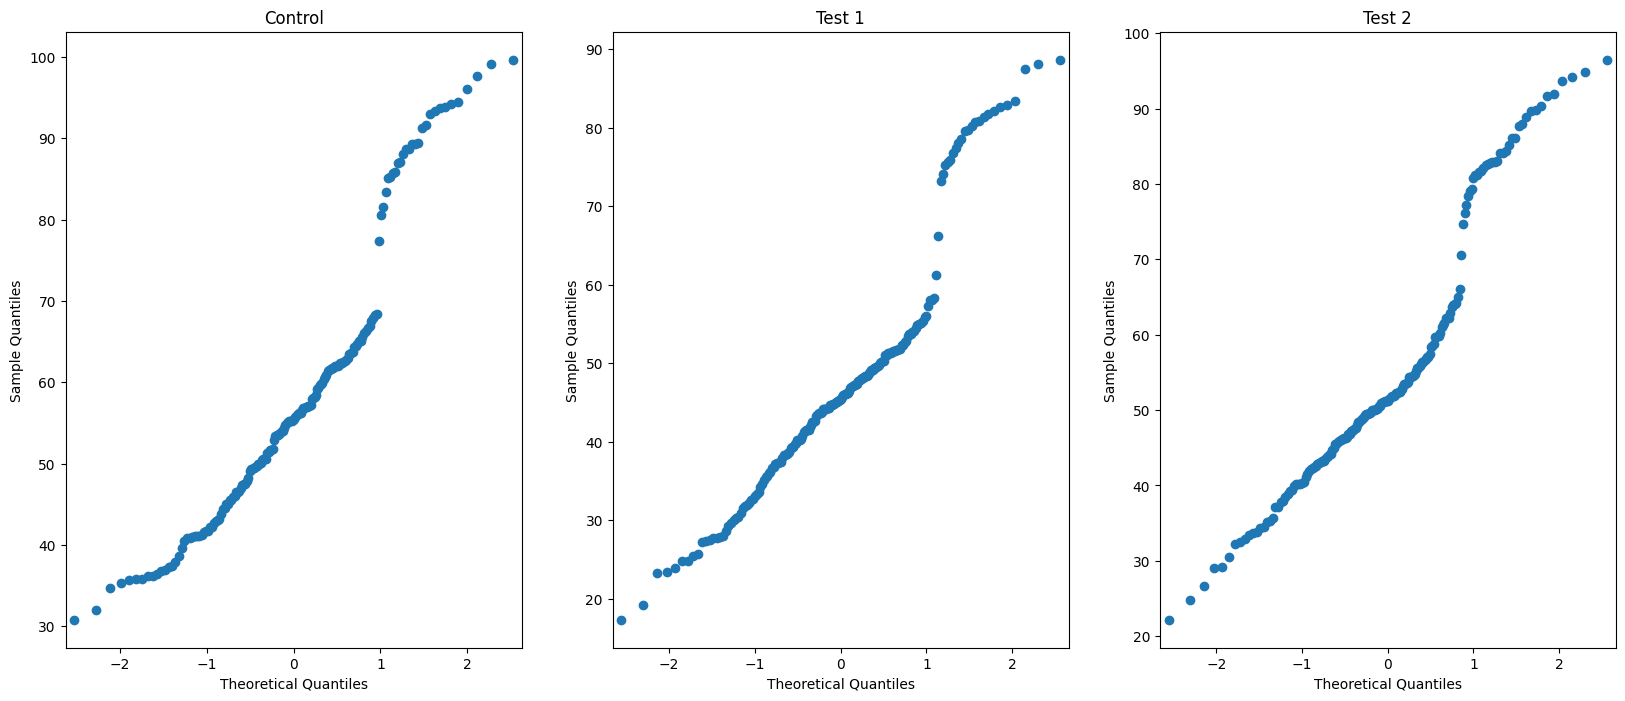

In [20]:
from statsmodels.graphics.gofplots import qqplot

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,8))

ax1.set_title('Control')
ax2.set_title('Test 1')
ax3.set_title('Test 2')

qqplot(control['SalesInThousands'], ax=ax1)
qqplot(test_1['SalesInThousands'], ax=ax2)
qqplot(test_2['SalesInThousands'], ax=ax3)

plt.show()

In [17]:
# We could check further by using Shapiro-Wilk test

for group in [control['SalesInThousands'], test_1['SalesInThousands'], test_2['SalesInThousands']]:
    print(stats.shapiro(group))
    print()

ShapiroResult(statistic=0.9152998328208923, pvalue=1.9772498305314912e-08)

ShapiroResult(statistic=0.9145088195800781, pvalue=5.456247009760773e-09)

ShapiroResult(statistic=0.9207685589790344, pvalue=1.499518376135711e-08)



All p-values are smaller than our alpha, so we reject the null hypothesis and can say that there is strong evidence that the samples do not follow a normal distribution.

In [21]:
# Check homoscedasticity of variances

stats.levene(control['SalesInThousands'], test_1['SalesInThousands'], test_2['SalesInThousands'])

LeveneResult(statistic=1.2696787527507418, pvalue=0.2817514565692118)

We fail to reject the null hypothesis: We cannot reject the hypothesis that the groups' variances have homoscedasticity

## Hypothesis Testing
Let mui be the population mean of i.

H0 (Null) : mu1 = mu2 = mu3
H1 (Alternative) : mu1, mu2, or mu3 are not equal

In [15]:
# Since the QQ plots closely resemble a straight line, and we have a large group size,
# ANOVA can be robust to failure of normality assumption

stats.f_oneway(control['SalesInThousands'], test_1['SalesInThousands'], test_2['SalesInThousands'])

F_onewayResult(statistic=21.953485793080677, pvalue=6.765849261408714e-10)

In [14]:
# Since normality assumption is not met, one test that can be used is 
# the Kruskal-Wallis test if we are unsure about ANOVA results

stats.kruskal(control['SalesInThousands'], test_1['SalesInThousands'], test_2['SalesInThousands'])

KruskalResult(statistic=53.29475169322799, pvalue=2.6741866266697816e-12)

Regardless of which test is used, the p-value is less than 0.05, meaning we reject the null hypothesis and can say that there is a statistically significant difference between the means of the groups.

## Post-hoc Test

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-10.7696,0.0,-14.7738,-6.7654,True
1,3,-2.7345,0.2444,-6.7388,1.2697,False
2,3,8.0351,0.0,4.1208,11.9493,True


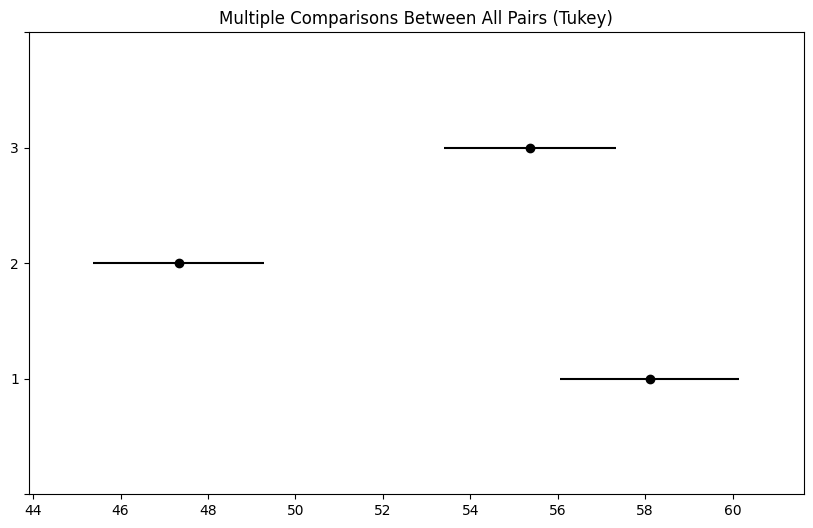

In [26]:
# Which one of the groups had a statistically significant difference?

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_test = pairwise_tukeyhsd(df['SalesInThousands'], groups=df['Promotion'], alpha=0.05)

tukey_test.plot_simultaneous()

tukey_test.summary()


It seems like group 2 (Test_1) had the worst performance of the three groups with both groups 1 (control) and group 3 (Test_2) showing a statistically significant difference. However, the same cannot be said between groups 1 and 3. Assuming that group 1 is the control group, based on this analysis it would make sense for the fast food chain to stop their marketing promotion efforts from group 3 and stick with group 1, while looking for other alternatives that might offer better results.